<a href="https://colab.research.google.com/github/margaretmz/CartoonGAN-e2e-tflite-tutorial/blob/master/ml/CartoonGAN_TFLite_Fixed_Shaped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the TFLite model conversion process for the **White-box Cartoonization** model as proposed in the paper [Learning to Cartoonize Using White-box Cartoon Representations](https://github.com/SystemErrorWang/White-box-Cartoonization/blob/master/paper/06791.pdf). Below you can find an example output that this model is capable of producing:

![](https://i.ibb.co/DkzL9J7/Screen-Shot-2020-07-21-at-1-42-25-PM.png)

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;[GitHub repository of the paper](https://github.com/SystemErrorWang/White-box-Cartoonization)


[steubk](https://www.kaggle.com/steubk) used the original code repository of the paper and [developed scripts](https://github.com/steubk/White-box-Cartoonization/tree/inference-tf-2.x) to run inference with the pre-trained model weights in TensorFlow 2. He also prepared a [Kaggle Kernel](https://www.kaggle.com/steubk/the-night-fellini-met-miyazaki) to demonstrate the inference workflow. Thtis notebook uses the Kaggle Kernel as a reference. 


**Acknowledgements**: Khanh LeViet

## Setup and imports

We will be using `tf-nightly` because during the time of developing this notebook `tf-nightly` only supported exporting TFLite models with dynamic shapes. This notebook uses different [post-training quantization recipes in TFLite](https://www.tensorflow.org/lite/performance/post_training_quantization) to generate different TFLite models. It's important to note that during applying `float16` quantization the model would still exported with a static shape.

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 323.8MB 32kB/s 
     |████████████████████████████████| 460kB 50.0MB/s 
     |████████████████████████████████| 6.7MB 43.6MB/s 


In [2]:
!git clone --branch inference-tf-2.x https://github.com/steubk/White-box-Cartoonization.git
!pip install --upgrade tf_slim

Cloning into 'White-box-Cartoonization'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 188 (delta 2), reused 2 (delta 0), pack-reused 175
Receiving objects: 100% (188/188), 63.41 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (61/61), done.
     |████████████████████████████████| 358kB 2.7MB/s 


In [3]:
import sys
sys.path.append('./White-box-Cartoonization/test_code')

import matplotlib.pyplot as plt
import cartoonize
import os

from PIL import Image

## Gather sample data and run inference to make sure the model works

In [4]:
!mkdir ./source-frames
!wget -O image.jpg https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg
!mv image.jpg ./source-frames/

--2020-08-04 05:03:04--  https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111191 (109K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 108.58K  --.-KB/s    in 0.04s   

2020-08-04 05:03:04 (2.78 MB/s) - ‘image.jpg’ saved [111191/111191]



Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


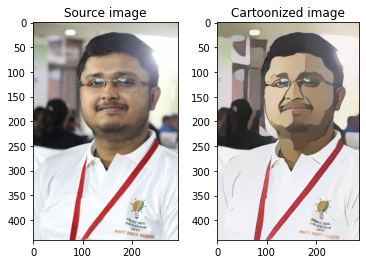

In [5]:
model_path = './White-box-Cartoonization/test_code/saved_models'
load_folder = './source-frames'
save_folder = './cartoonized_images'
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
cartoonize.cartoonize(load_folder, save_folder, model_path)

source_image = plt.imread('./source-frames/image.jpg')
cartoonized_image = plt.imread('./cartoonized_images/image.jpg')

plt.subplot(1, 2, 1)
plt.imshow(source_image)
plt.title('Source image')
plt.subplot(1, 2, 2)
plt.imshow(cartoonized_image)
plt.title('Cartoonized image')
plt.show()

## Create a `SavedModel` from the pre-trained checkpoints

In [6]:
# Directory where SavedModel is to be saved
!mkdir saved_model_dir

In [7]:
# Comes with the GitHub repo
# These will be needed to instantiate the model
import network
import guided_filter

In [8]:
# We will be using TensorFlow session
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [9]:
tf.reset_default_graph()
  
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
  # Create placeholder for the input
  input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name='input_photo')
  
  # Run the input placeholder through the generator, and then apply a 
  # filter to process the generator output
  network_out = network.unet_generator(input_photo)
  final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)
  final_out = tf.identity(final_out, name='final_output') # Create an identical filtering layer 
 
  # The above process is basically needed to construct the computation graph for the
  # current session
  
  # Get the generator variables and restore the pre-trained checkpoints in the 
  # current session
  all_vars = tf.trainable_variables()
  gene_vars = [var for var in all_vars if 'generator' in var.name]
  saver = tf.train.Saver(var_list=gene_vars)
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, tf.train.latest_checkpoint(model_path))
  
  # Export to SavedModel
  tf.saved_model.simple_save(
      sess,
      '/content/saved_model_dir',
      inputs={input_photo.name: input_photo},
      outputs={final_out.name: final_out})

INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/saved_model_dir/saved_model.pb


### Inspect the files sizes 

In [10]:
!ls -lh saved_model_dir
!ls -lh saved_model_dir/variables

total 144K
-rw-r--r-- 1 root root 137K Aug  4 05:03 saved_model.pb
drwxr-xr-x 2 root root 4.0K Aug  4 05:03 variables
total 5.7M
-rw-r--r-- 1 root root 5.6M Aug  4 05:03 variables.data-00000-of-00001
-rw-r--r-- 1 root root 1.6K Aug  4 05:03 variables.index


In [11]:
!ls -lh /content/White-box-Cartoonization/test_code/saved_models

total 5.7M
-rw-r--r-- 1 root root  121 Aug  4 05:02 checkpoint
-rw-r--r-- 1 root root 5.6M Aug  4 05:02 model-33999.data-00000-of-00001
-rw-r--r-- 1 root root 1.6K Aug  4 05:02 model-33999.index


**A runtime restart is required here.**

# TFLite model conversion

## Imports 

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.executing_eagerly())

2.4.0-dev20200803
True


In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

## Dynamic-range quantization

In [3]:
model = tf.saved_model.load('saved_model_dir')
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 512, 512, 3]) # Just comment this line if you want to export a model with dynamic shape support
    
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open('whitebox_cartoon_gan_dr.tflite', 'wb').write(tflite_model)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


2568976

In [4]:
!ls -lh whitebox_cartoon_gan_dr.tflite

-rw-r--r-- 1 root root 2.5M Aug  4 05:07 whitebox_cartoon_gan_dr.tflite


## float16 quantization

In [5]:
# TFLite GPU delegate does not support dynamic-shaped inputs
# So, we need to export the float16 quantized model in a way such that it 
# only uses static input shapes
model = tf.saved_model.load('saved_model_dir')
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 512, 512, 3])
    
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

open('whitebox_cartoon_gan_fp16.tflite', 'wb').write(tflite_model)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


3481632

In [6]:
!ls -lh whitebox_cartoon_gan_fp16.tflite

-rw-r--r-- 1 root root 3.4M Aug  4 05:07 whitebox_cartoon_gan_fp16.tflite


## int8 quantization

In [ ]:
# Gather some more data
!wget -O image2.jpg https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg
!wget -O image3.jpg https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg
!wget -O image4.jpg https://pbs.twimg.com/profile_images/1260205070555086855/erU_iILT_400x400.jpg
!wget -O image5.jpg https://pbs.twimg.com/profile_images/1235595938921459713/h26CpAPb_400x400.jpg

In [8]:
# Put these images in a central directory
!cp -r *.jpg source-frames/

In [9]:
IMG_SIZE = 512
images_list = os.listdir('/content/source-frames')

# int8 quantization requires a representative dataset generator
def representative_dataset_gen():
    for image_path in images_list:
        image = cv2.imread(os.path.join('/content/source-frames', image_path))
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype(np.float32)/127.5 - 1
        image = np.expand_dims(image, axis=0)
        yield [image]

model = tf.saved_model.load('saved_model_dir')
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, IMG_SIZE, IMG_SIZE, 3])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

open('whitebox_cartoon_gan_int8.tflite', 'wb').write(tflite_model)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


1808784

In [10]:
!ls -lh whitebox_cartoon_gan_int8.tflite

-rw-r--r-- 1 root root 1.8M Aug  4 05:08 whitebox_cartoon_gan_int8.tflite


## Sample inference

In [11]:
# Reference: https://www.tensorflow.org/lite/models/style_transfer/overview
def load_img(path_to_img):
  img = cv2.imread(path_to_img)
  img = img.astype(np.float32) / 127.5 - 1
  img = np.expand_dims(img, 0)
  img = tf.convert_to_tensor(img)
  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim=224):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [12]:
source_image = load_img('/content/source-frames/image.jpg')
preprocessed_source_image = preprocess_image(source_image, target_dim=512)
preprocessed_source_image.shape

TensorShape([1, 512, 512, 3])

In [19]:
#@title Run inference
model_type = "dr" #@param ["dr", "int8", "float16"]

model_dict = {
    "dr": "/content/whitebox_cartoon_gan_dr.tflite",
    "int8": "/content/whitebox_cartoon_gan_int8.tflite",
    "float16": "/content/whitebox_cartoon_gan_fp16.tflite"
}

interpreter = tf.lite.Interpreter(model_path=model_dict[model_type])
input_details = interpreter.get_input_details()

# Comment out the following when dealing with models with dynamic shaped inputs
# if model_type == 'int8':
#     interpreter.resize_tensor_input(156, [1, preprocessed_source_image.shape[1], preprocessed_source_image.shape[2], 3]) 
# else:
#     interpreter.resize_tensor_input(0, [1, preprocessed_source_image.shape[1], preprocessed_source_image.shape[2], 3])

interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], preprocessed_source_image)
interpreter.invoke()

raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

## Process the output

In [20]:
output = (np.squeeze(raw_prediction)+1.0)*127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

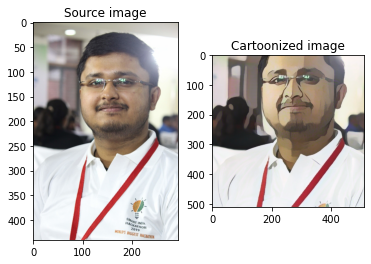

In [21]:
plt.subplot(1, 2, 1)
plt.imshow(plt.imread('/content/source-frames/image.jpg'))
plt.title('Source image')
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title('Cartoonized image')
plt.show()